# Final Project -- UEP0239 -- Hongkun Huang

## 1. Environment and Selected data

In [1]:
import rasterio
from rasterio.plot import show
from rasterio import features

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import richdem as rd
from scipy import ndimage
from shapely.geometry import box
from rasterstats import zonal_stats

In [2]:
with rasterio.open('E:/Tufts/2021 Spring/python/final/raster/NLCD/NLCD_2016_Land_Cover_Boston.tif') as raster:
    shape = raster.shape
    transform = raster.transform
    res = raster.res
    crs = raster.crs
    nodata = raster.nodata
    bounds = raster.bounds
    landcover = raster.read(1)
    meta = raster.meta

In [3]:
import contextily as cx

In [4]:
library = gpd.read_file('E:/Tufts/2021 Spring/python/final/vector/MassGIS/LIBRARIES_PT/LIBRARIES_PT.shp')

In [5]:
college = gpd.read_file('E:/Tufts/2021 Spring/python/final/vector/MassGIS/COLLEGES_PT/COLLEGES_PT.shp')

In [6]:
school = gpd.read_file('E:/Tufts/2021 Spring/python/final/vector/MassGIS/SCHOOLS_PT/SCHOOLS_PT.shp')

In [7]:
Bus = gpd.read_file('E:/Tufts/2021 Spring/python/final/vector/MassDOT/MBTA_Bus_Stops/MBTA_Bus_Stops.shp')

In [8]:
zcta = gpd.read_file('E:/Tufts/2021 Spring/python/final/vector/Census/tl_2010_25_zcta510/tl_2010_25_zcta510.shp')

In [9]:
MPO = gpd.read_file('E:/Tufts/2021 Spring/python/final/vector/MassDOT/MPO_Boundaries/MPO_Boundaries.shp')

## Summary:
The theme of my project was to explore the most suitable areas for new libraries in the Boston area. Each ZCTA was scored by suitability analysis, and the area with the highest score was the most suitable ZCTA for new libraries. And compare the number of existing libraries in the region to determine the final result.

I utilized a total of six weighting factors, and the areas with the highest scores had the following characteristics: far from existing libraries, mear to universities and general schools, near to bus stops, and a land category of Developed space. 

All coordinate systems are adjusted to EPSG:6491

## Note: In this analysis, I chose a total of six indicators in BostonMPO area: 
1. distance to existing libraries; 
2. distance to universities; 
3. distance to general schools; 
4. distance to bus stops; 
5. land coverage category; 
6. number of existing libraries in each ZCTA

## 2. Clip Study Area (Boston Region)

In [170]:
zcta

STATEFP10 ZCTA5CE10  GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10    ALAND10  \
0          25     02536  2502536        B5   G6350          S   71696166   
1          25     02556  2502556        B5   G6350          S   10034104   
2          25     02540  2502540        B5   G6350          S   27746696   
3          25     02646  2502646        B5   G6350          S    7798581   
4          25     01237  2501237        B5   G6350          S  160121626   
..        ...       ...      ...       ...     ...        ...        ...   
533        25     01537  2501537        B5   G6350          S   18085937   
534        25     01503  2501503        B5   G6350          S   33598202   
535        25     01452  2501452        B5   G6350          S  106373488   
536        25     01571  2501571        B5   G6350          S   53915863   
537        25     01468  2501468        B5   G6350          S   55425624   

     AWATER10   INTPTLAT10    INTPTLON10 PARTFLG10  \
0     9066635  +41.5969756  -070.5678768         N   
1     1164445  +41.6394454  -070.6245149         N   
2     4550024  +41.5741900  -070.6282848         N   
3      801405  +41.6705961  -070.0714493         N   
4     1140685  +42.5478177  -073.2680327         N   
..        ...          ...           ...       ...   
533    295745  +42.1589660  -071.8970514         N   
534    523984  +42.3849290  -071.6338895         N   
535   2406515  +42.4895983  -072.0028783         N   
536   2717076  +42.0537777  -071.9350751         N   
537    688465  +42.5427668  -072.0683447         N   

                                              geometry  
0    POLYGON ((-70.59239 41.56006, -70.59268 41.559...  
1    POLYGON ((-70.62389 41.61673, -70.62633 41.617...  
2    POLYGON ((-70.62389 41.61673, -70.62262 41.616...  
3    POLYGON ((-70.07925 41.67769, -70.07864 41.677...  
4    POLYGON ((-73.23558 42.49333, -73.23587 42.493...  
..                                                 ...  
533  POLYGON ((-71.89793 42.18884, -71.89791 42.188...  
534  POLYGON ((-71.58830 42.38197, -71.58961 42.381...  
535  POLYGON ((-72.04222 42.44499, -72.04371 42.446...  
536  POLYGON ((-71.93992 42.02558, -71.94414 42.025...  
537  POLYGON ((-72.07856 42.58179, -72.07848 42.582...  

[538 rows x 12 columns]

Text(0.5, 0.98, 'ZCTA in MA')

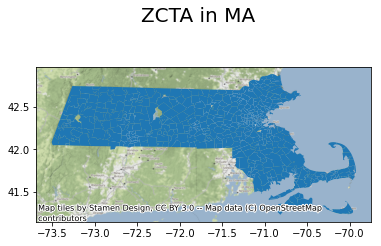

In [171]:
zctaax = zcta.plot(legend=True)
cx.add_basemap(zctaax, crs=zcta.crs.to_string());
plt.suptitle('ZCTA in MA', fontsize=20)

In [172]:
MPO.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Text(0.5, 0.98, 'MPO in MA')

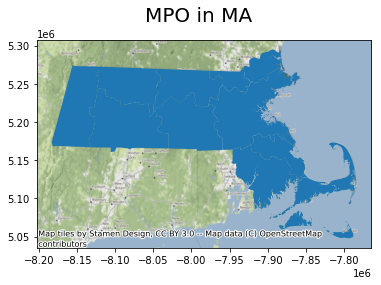

In [173]:
MPOax = MPO.plot(legend=True)
cx.add_basemap(MPOax, crs=MPO.crs.to_string());
plt.suptitle('MPO in MA', fontsize=20)

In [174]:
# Clip to get Boston Region
MPO_Boston =MPO[MPO['MPO'] == 'Boston Region']
MPO_Boston

OBJECTID            MPO created_us  created_da last_edite  last_edi_1  \
10        12  Boston Region       None  1970-01-01   DINOCCOD  2018-04-18   

                                  GlobalID    ShapeSTAre    ShapeSTLen  \
10  {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   

                                             geometry  
10  MULTIPOLYGON (((-7875339.226 5247387.185, -787...

Text(0.5, 0.98, 'MPO in Boston')

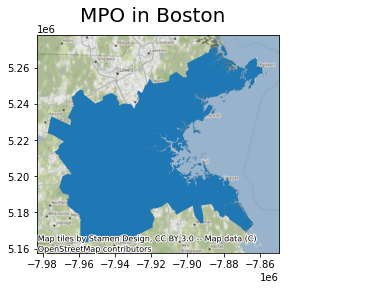

In [175]:
MPO_Bostonax = MPO_Boston.plot(legend=True)
cx.add_basemap(MPO_Bostonax, crs=MPO_Boston.crs.to_string());
plt.suptitle('MPO in Boston', fontsize=20)

In [176]:
MPO_Boston6491 = MPO_Boston.to_crs('epsg:6491')

In [177]:
zcta6491 = zcta.to_crs('epsg:6491')

In [178]:
zctaBoston = gpd.overlay( zcta6491, MPO_Boston6491,how='intersection')

In [179]:
zctaBoston

STATEFP10 ZCTA5CE10  GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10   ALAND10  \
0          25     01905  2501905        B5   G6350          S   9219345   
1          25     01904  2501904        B5   G6350          S  11708211   
2          25     01930  2501930        B5   G6350          S  67847425   
3          25     01915  2501915        B5   G6350          S  39091336   
4          25     01921  2501921        B5   G6350          S  61010486   
..        ...       ...      ...       ...     ...        ...       ...   
192        25     02129  2502129        B5   G6350          S   3492181   
193        25     02128  2502128        B5   G6350          S  12561059   
194        25     02122  2502122        B5   G6350          S   5263269   
195        25     02151  2502151        B5   G6350          S  15190546   
196        25     01503  2501503        B5   G6350          S  33598202   

     AWATER10   INTPTLAT10    INTPTLON10  ... OBJECTID            MPO  \
0     1195154  +42.4659985  -070.9757922  ...       12  Boston Region   
1     1303900  +42.4924563  -070.9739297  ...       12  Boston Region   
2    13972397  +42.6199100  -070.6818235  ...       12  Boston Region   
3     3958118  +42.5702688  -070.8669962  ...       12  Boston Region   
4     2188501  +42.6831083  -071.0183302  ...       12  Boston Region   
..        ...          ...           ...  ...      ...            ...   
192   1266666  +42.3796570  -071.0614875  ...       12  Boston Region   
193   2952872  +42.3611289  -071.0069754  ...       12  Boston Region   
194   1641767  +42.2914125  -071.0421575  ...       12  Boston Region   
195   3291332  +42.4182938  -071.0012566  ...       12  Boston Region   
196    523984  +42.3849290  -071.6338895  ...       12  Boston Region   

    created_us  created_da last_edite  last_edi_1  \
0         None  1970-01-01   DINOCCOD  2018-04-18   
1         None  1970-01-01   DINOCCOD  2018-04-18   
2         None  1970-01-01   DINOCCOD  2018-04-18   
3         None  1970-01-01   DINOCCOD  2018-04-18   
4         None  1970-01-01   DINOCCOD  2018-04-18   
..         ...         ...        ...         ...   
192       None  1970-01-01   DINOCCOD  2018-04-18   
193       None  1970-01-01   DINOCCOD  2018-04-18   
194       None  1970-01-01   DINOCCOD  2018-04-18   
195       None  1970-01-01   DINOCCOD  2018-04-18   
196       None  1970-01-01   DINOCCOD  2018-04-18   

                                   GlobalID    ShapeSTAre    ShapeSTLen  \
0    {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   
1    {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   
2    {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   
3    {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   
4    {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   
..                                      ...           ...           ...   
192  {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   
193  {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   
194  {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   
195  {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   
196  {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   

                                              geometry  
0    MULTIPOLYGON (((244312.370 910601.650, 244313....  
1    POLYGON ((245700.484 914778.700, 245667.412 91...  
2    MULTIPOLYGON (((266237.574 925818.224, 266244....  
3    MULTIPOLYGON (((250314.063 920830.142, 250314....  
4    MULTIPOLYGON (((242819.169 930226.474, 242826....  
..                                                 ...  
192  MULTIPOLYGON (((235374.775 902519.214, 235372....  
193  MULTIPOLYGON (((240343.022 905113.584, 240312....  
194  MULTIPOLYGON (((237251.745 892010.100, 237257....  
195  MULTIPOLYGON (((242209.600 904395.398, 242209....  
196  MULTIPOLYGON (((190444.641 900460.257, 190380....  

[19

Text(0.5, 0.98, 'ZCTA in Boston')

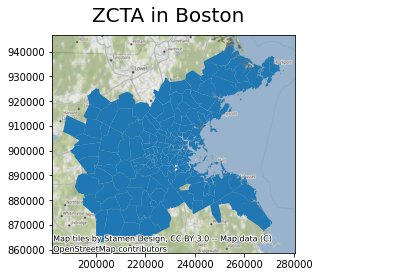

In [180]:
b = zctaBoston.plot(legend=True)
cx.add_basemap(b, crs=zctaBoston.crs.to_string());
plt.suptitle('ZCTA in Boston', fontsize=20)

Text(0.5, 0.98, 'ZCTA in Boston Region')

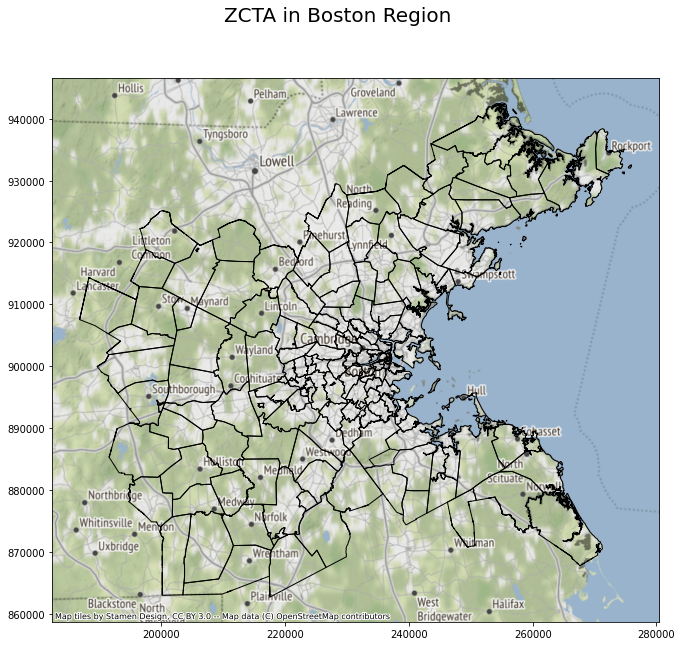

In [181]:
zctaBostonax = zctaBoston.plot(figsize=(20, 10), facecolor='None', edgecolor='black')
cx.add_basemap(zctaBostonax, crs=zctaBoston.crs.to_string());
plt.suptitle('ZCTA in Boston Region', fontsize=20)

## 3. Visualize Spatial data (Rasterize / Euclidean Distance / Reclassify / Attribute join)

### 3.1 Euclidean Distance to Libraries and Reclassify

In [182]:
library

NAME               ADDRESS         TOWN STATE  \
0          EGREMONT FREE LIBRARY     1 BUTTONBALL LANE     EGREMONT    MA   
1    FLORIDA FREE PUBLIC LIBRARY  56 NORTH COUNTY ROAD      FLORIDA    MA   
2         HOLYOKE PUBLIC LIBRARY   250 CHESTNUT STREET      HOLYOKE    MA   
3    MASON SQUARE BRANCH LIBRARY      765 STATE STREET  SPRINGFIELD    MA   
4     NORTH ADAMS PUBLIC LIBRARY      74 CHURCH STREET  NORTH ADAMS    MA   
..                           ...                   ...          ...   ...   
465   MIDDLEFIELD PUBLIC LIBRARY     188 SKYLINE TRAIL  MIDDLEFIELD    MA   
466    GRISWOLD MEMORIAL LIBRARY          12 MAIN ROAD      COLRAIN    MA   
467       TYLER MEMORIAL LIBRARY       157 MAIN STREET   CHARLEMONT    MA   
468   WESTHAMPTON PUBLIC LIBRARY          1 NORTH ROAD  WESTHAMPTON    MA   
469  WINDSOR FREE PUBLIC LIBRARY          1890 ROUTE 9      WINDSOR    MA   

       ZIP           TYPE       ADDRESS_PO                LIBKEY  NETWORK  \
0    01230         PUBLIC   M_42081_880811      PU-EGREMONT-FREE  C/WMARS   
1    01247         PUBLIC   M_73999_939186       PU-FLORIDA-FREE  C/WMARS   
2    01040         PUBLIC  M_108126_884338     PU-HOLYOKE-PUBLIC  C/WMARS   
3    01109  PUBLIC BRANCH  M_111823_873863      PU-SPRINGFI-CITY  C/WMARS   
4    01247         PUBLIC   M_68185_939879      PU-NADAMS-PUBLIC  C/WMARS   
..     ...            ...              ...                   ...      ...   
465  01243         PUBLIC   M_75622_900447    PU-MIDDLEFI-PUBLIC     None   
466  01340         PUBLIC  M_101678_936447   PU-COLRAIN-GRISWOLD  C/WMARS   
467  01339         PUBLIC   M_87563_931780     PU-CHARLEMO-TYLER  C/WMARS   
468  01027         PUBLIC   M_94935_895687  PU-WESTHAMP-MEMORIAL  C/WMARS   
469  01270         PUBLIC   M_72011_919002       PU-WINDSOR-FREE     None   

      REGION DELIVROUTE                                            WEBSITE  \
0    Western     Optima                            http://egremont-ma.gov/   
1    Western     Optima                                               None   
2    Western     Optima                      http://www.holyokelibrary.org   
3    Western     Optima                 http://www.springfieldlibrary.org/   
4    Western     Optima                          http://www.naplibrary.com   
..       ...        ...                                                ...   
465  Western     Optima              http://middlefieldma.net/?page_id=172   
466  Western     Optima     http://colrain-ma.gov/departments/library.html   
467  Western     Optima  http://www.charlemont-ma.us/town/tyler-memoria...   
468  Western     Optima  https://www.westhampton-ma.com/westhampton-pub...   
469  Western     Optima  http://www.windsormass.com/windsor-public-library   

                          geometry  
0     POINT (42080.824 880810.865)  
1     POINT (73998.820 939185.588)  
2    POINT (108125.885 884337.953)  
3    POINT (111822.608 873862.592)  
4     POINT (68185.483 939879.244)  
..                             ...  
465   POINT (75613.611 900456.660)  
466  POINT (101678.371 936446.501)  
467   POINT (87563.123 931783.458)  
468   POINT (94935.281 895687.373)  
469   POINT (72011.609 919002.047)  

[470 rows x 13 columns]

Text(0.5, 0.98, 'Libraries in MA')

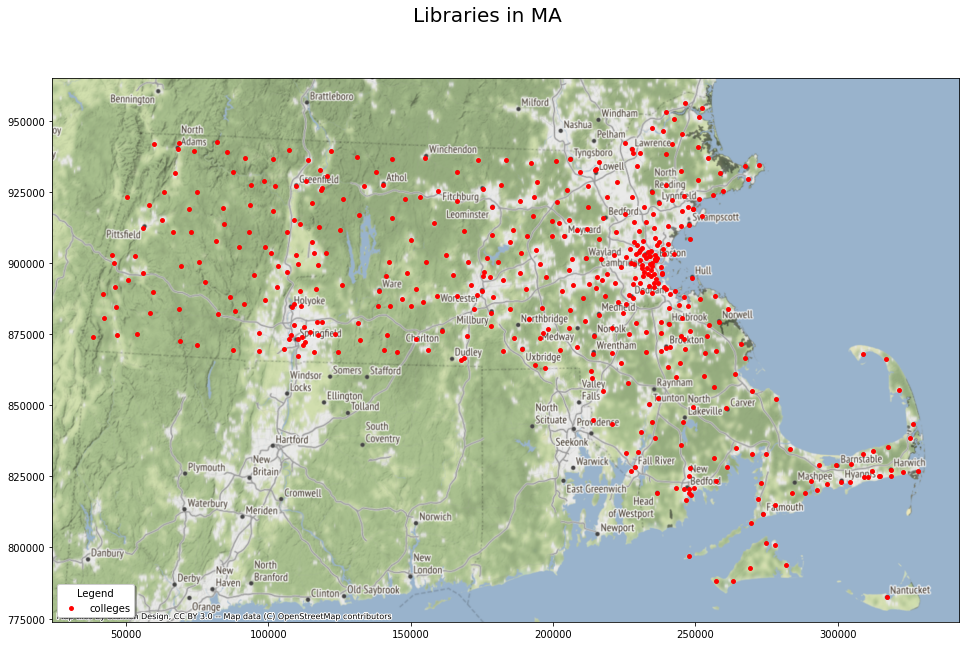

In [183]:
libraryax = library.plot(figsize=(20, 10), legend=True, markersize=15 , label='colleges' ,  color='red')
cx.add_basemap(libraryax, crs=zctaBoston.crs.to_string());
libraryax.legend(title="Legend", loc='lower left', ncol=1, shadow=True)
plt.suptitle('Libraries in MA', fontsize=20)

In [184]:
library6491 = library.to_crs('epsg:6491')

In [185]:
library_raster = features.rasterize(library6491['geometry'], out_shape=shape, fill=1, transform=transform, default_value=0)

In [186]:
library_distance = ndimage.distance_transform_edt(library_raster) * res[0]

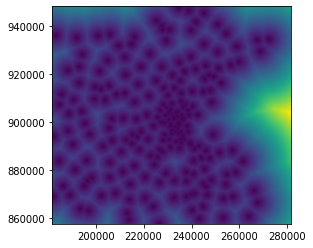

<AxesSubplot:>

In [187]:
show(library_distance, transform=transform)

In [188]:
library_distance

array([[12303.65799265, 12299.45120727, 12295.31618138, ...,
        16567.22668403, 16583.59731783, 16600.0060241 ],
       [12273.9602411 , 12269.7432736 , 12265.59823245, ...,
        16542.08269838, 16558.47819094, 16574.91176447],
       [12244.26396318, 12240.03676465, 12235.8816601 , ...,
        16516.95492517, 16533.37533597, 16549.83383602],
       ...,
       [11412.78230757, 11411.40219254, 11410.10078834, ...,
        16318.29035163, 16343.50329642, 16368.73238831],
       [11442.74879563, 11441.37229531, 11440.07430046, ...,
        16334.5798844 , 16359.76772451, 16384.97177294],
       [11472.71545886, 11471.34255438, 11470.04795108, ...,
        16350.90823165, 16376.07095735, 16401.24995237]])

In [189]:
# Reclassify
library_reclass = np.full(shape, np.NaN)
library_reclass[library_distance <= 1000] = 1
library_reclass[(library_distance > 1000) & (library_distance <= 2500)] = 2
library_reclass[(library_distance > 2500) & (library_distance <= 5000)] = 3
library_reclass[(library_distance > 5000) & (library_distance <= 7500)] = 4
library_reclass[library_distance > 7500] = 5

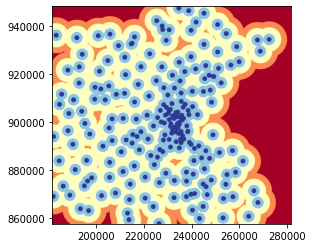

In [190]:
show(library_reclass, transform=transform, cmap='RdYlBu_r')
plt.show()

### 3.2 Euclidean Distance to colleges and Reclassify

In [191]:
college

COLLEGE       CAMPUS  \
0                           Cape Cod Electrical School         None   
1                           Cape Cod Community College  Main Campus   
2                                      Rob Roy Academy   Fall River   
3    Diman Regional Technical Institute Division of...         None   
4                            Bristol Community College   Fall River   
..                                                 ...          ...   
240                                         Hair's How         None   
241                             Salem State University         None   
242                  Conway School of Landscape Design  Main Campus   
243                        Middlesex Community College      Bedford   
244                                  Face Forward, Inc         None   

                      ADDRESS             CITY ZIPCODE PLUS_FOUR   GEOG_TOWN  \
0         9 New Venture Drive     South Dennis   02660      None      DENNIS   
1          2240 Iyanough Road  West Barnstable   02668      1599  BARNSTABLE   
2           260 S Main Street       Fall River   02720      None  FALL RIVER   
3         251 Stonehaven Road       Fall River   02723      None  FALL RIVER   
4          777 Elsbree Street       Fall River   02720      None  FALL RIVER   
..                        ...              ...     ...       ...         ...   
240         99 Preston Street        Wakefield   01880      None   WAKEFIELD   
241      352 Lafayette Street            Salem   01970      5353       SALEM   
242  332 South Deerfield Road           Conway   01341      None      CONWAY   
243          591 Springs Road          Bedford   01730      None     BEDFORD   
244    83 Pine Street, Unit B          Peabody   01960      None     PEABODY   

           MAIN_TEL                                         URL NCES_ID TYPE  \
0    (508) 760-1983         http://capecodelectricalschool.com/    None  PRI   
1    (508) 362-2131                     http://www.capecod.edu/  165194  PUB   
2    (508) 672-4751                      http://www.rob-roy.com  165750  PRI   
3    (508) 678-2891   https://www.dimanregional.org/domain/1100  165608  PUB   
4    (508) 678-2811                    http://www.bristolcc.edu  165033  PUB   
..              ...                                         ...     ...  ...   
240  (781) 224-4800  http://www.hairshowschool.com/welcome.html    None  PRI   
241  (978) 542-6000                   http://www.salemstate.edu  167729  PUB   
242  (413) 369-4044                         http://www.csld.edu  165495  PRI   
243  (781) 280-3200                 http://www.middlesex.ma.edu  166887  PUB   
244  (978) 535-5888             https://www.faceforwardinc.com/    None  PRI   

                          NCES_TYPE                      CATEGORY  \
0      < 2-year, Private for-profit  Private Occupational Program   
1                    2-year, Public             Community College   
2      < 2-year, Private for-profit     Private Vocational School   
3                  < 2-year, Public               Adult Education   
4                    2-year, Public             Community College   
..                              ...                           ...   
240    < 2-year, Private for-profit     Private Vocational School   
241                  4-year, Public              State University   
242  4-year, Private not-for-profit    Graduate Landscape Program   
243                  2-year, Public             Community College   
244    < 2-year, Private for-profit     Private Vocational School   

         DEGREEOFFR                                         AWARDSOFFR  \
0                 C  Journeyman, Master, Systems Technician, System...   
1              C, A  Less than one year certificate;Associate's degree   
2                 C            One but less than two years certificate   
3                 C            One but less than two years certificate   
4              C, A  Less than one year certificate;Associate's degree   

Text(0.5, 0.98, 'colleges in MA')

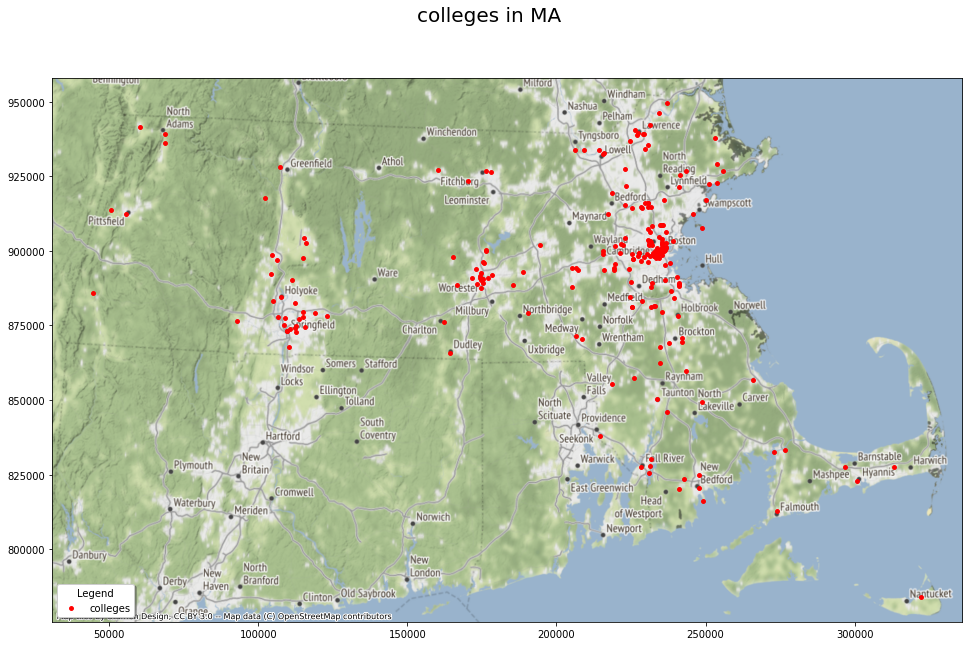

In [192]:
collegeax = college.plot(figsize=(20, 10), legend=True , markersize=15 , label='colleges' ,  color='red')
cx.add_basemap(collegeax, crs=zctaBoston.crs.to_string());
collegeax.legend(title="Legend", loc='lower left', ncol=1, shadow=True)
plt.suptitle('colleges in MA', fontsize=20)

In [193]:
college6491 = college.to_crs('epsg:6491')

In [194]:
college_raster = features.rasterize(college6491['geometry'], out_shape=shape, fill=1, transform=transform, default_value=0)

In [195]:
college_distance = ndimage.distance_transform_edt(college_raster) * res[0]

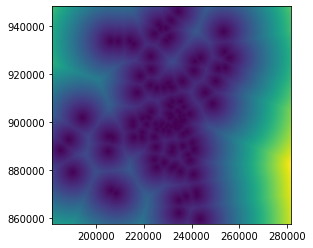

In [196]:
show(college_distance, transform=transform)
plt.show()

In [197]:
college_distance

array([[28477.58592297, 28451.80134895, 28426.02504748, ...,
        29965.05965287, 29993.11420976, 30021.17252873],
       [28462.26976191, 28436.47130008, 28410.68109004, ...,
        29954.44040539, 29982.50489869, 30010.57313681],
       [28446.97699229, 28421.1646489 , 28395.36053654, ...,
        29943.84744818, 29971.9218603 , 30000.        ],
       ...,
       [23074.50541182, 23063.36705687, 23052.26236186, ...,
        37856.63614216, 37886.5912956 , 37916.54651996],
       [23102.35702261, 23091.23210225, 23080.14081413, ...,
        37858.28839237, 37888.24223951, 37918.19615963],
       [23130.21400679, 23119.10249123, 23108.02458022, ...,
        37859.9643423 , 37889.91686452, 37919.8694618 ]])

In [198]:
# Reclassify
college_reclass = np.full(shape, np.NaN)
college_reclass[college_distance <= 1000] = 5
college_reclass[(college_distance > 1000) & (college_distance <= 2500)] = 4
college_reclass[(college_distance > 2500) & (college_distance <= 5000)] = 3
college_reclass[(college_distance > 5000) & (college_distance <= 7500)] = 2
college_reclass[college_distance > 7500] = 1

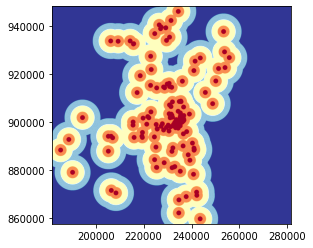

In [199]:
show(college_reclass, transform=transform, cmap='RdYlBu_r')
plt.show()

### 3.3 Euclidean Distance to schools and Reclassify

In [200]:
school

SCHID                                    NAME  \
0     03090020      Stanley M Koziol Elementary School   
1     06220010             Millville Elementary School   
2     00440080              Frederick Douglass Academy   
3     04560050  Lowell Community Charter Public School   
4     02390005                      Cold Spring School   
...        ...                                     ...   
2454  04390050         Conservatory Lab Charter School   
2455  01490890       Notre Dame Cristo Rey High School   
2456  01140505                  Greenfield High School   
2457  02010803               Early Learning Child Care   
2458  02530005                         Rowe Elementary   

                     ADDRESS    TOWN_MAIL         TOWN ZIPCODE         PHONE  \
0               4 Gould Road         Ware         WARE   01082  413-967-6236   
1        122 Berthelette Way    Millville    MILLVILLE   01529  508-876-0177   
2          175 Warren Avenue     Brockton     BROCKTON   02301  508-580-7033   
3         206 Jackson Street       Lowell       LOWELL   01852  978-323-0800   
4            25 Alden Street     Plymouth     PLYMOUTH   02360  508-830-4335   
...                      ...          ...          ...     ...           ...   
2454  2120 Dorchester Avenue   Dorchester       BOSTON   02124  617-254-8904   
2455    303 Haverhill Street     Lawrence     LAWRENCE   01840  978-689-8222   
2456          21 Barr Avenue   Greenfield   GREENFIELD   01301  413-772-1350   
2457     322 Maxfield Street  New Bedford  NEW BEDFORD   02740  508-996-3774   
2458            86 Pond Road         Rowe         ROWE   01367  413-512-5100   

                            GRADES TYPE          TYPE_DESC  \
0                    PK,K,01,02,03  ELE  Public Elementary   
1              PK,K,01,02,03,04,05  ELE  Public Elementary   
2             06,07,08,09,10,11,12  SEC   Public Secondary   
3     PK,K,01,02,03,04,05,06,07,08  CHA            Charter   
4                 K,01,02,03,04,05  ELE  Public Elementary   
...                            ...  ...                ...   
2454  PK,K,01,02,03,04,05,06,07,08  CHA            Charter   
2455                   09,10,11,12  PRI            Private   
2456                08,09,10,11,12  SEC   Public Secondary   
2457                            PK  PRI            Private   
2458              PK,K,1,2,3,4,5,6  ELE  Public Elementary   

                     DIST_NAME DIST_CODE    MAD_ID TYPE_DESC2  \
0                         Ware  03090000   1003108       None   
1         Blackstone-Millville  06220000   1708902       None   
2                     Brockton  00440000   3278046       None   
3     Lowell Community Charter  04560000   1978735       None   
4                     Plymouth  02390000   2176192       None   
...                        ...       ...       ...        ...   
2454  Conservatory Lab Charter  04390000  35164510       None   
2455                      None      None   2124790       None   
2456                Greenfield  01140000    214271       None   
2457                      None      None      None       None   
2458                      Rowe  02530000    722689       None   

                           geometry  
0     POINT (137104.992 889501.256)  
1     POINT (193535.347 864680.374)  
2     POINT (239410.709 870353.747)  
3     POINT (215408.324 932324.148)  
4     POINT (268146.542 857250.077)  
...                             ...  
2454  POINT (235821.855 891970.515)  
2455  POINT (227235.383 940010.302)  
2456  POINT (110192.653 928865.753)  
2457  POINT (246957.232 821204.731)  
2458   POINT (86223.556 940152.581)  

[2459 rows x 15 columns]

Text(0.5, 0.98, 'schools in MA')

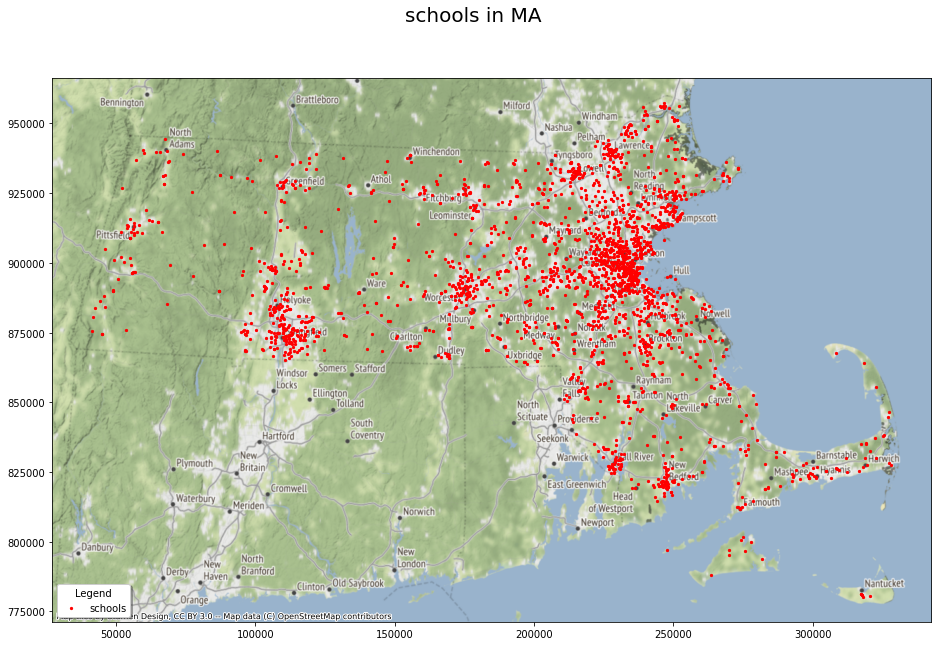

In [201]:
schoolax = school.plot(figsize=(20, 10), legend=True, markersize=5, label='schools', color='red')
cx.add_basemap(schoolax, crs=zctaBoston.crs.to_string());
schoolax.legend(title="Legend", loc='lower left', ncol=1, shadow=True)
plt.suptitle('schools in MA', fontsize=20)

In [202]:
school6491 = school.to_crs('epsg:6491')

In [203]:
school_raster = features.rasterize(school6491['geometry'], out_shape=shape, fill=1, transform=transform, default_value=0)

In [204]:
school_distance = ndimage.distance_transform_edt(school_raster) * res[0]

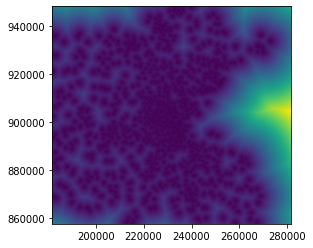

In [205]:
show(school_distance, transform=transform)
plt.show()

In [206]:
school_distance

array([[12377.17253657, 12373.86358418, 12370.6264999 , ...,
        16703.77801577, 16718.72303736, 16733.70849513],
       [12347.36004173, 12344.04309779, 12340.79819137, ...,
        16677.76064105, 16692.72895605, 16707.73772837],
       [12317.54845738, 12314.22348344, 12310.97071721, ...,
        16651.75666409, 16666.74833313, 16681.78048051],
       ...,
       [10954.97147418, 10950.49313958, 10946.09519418, ...,
        14030.06058433, 14060.01778093, 14089.97515967],
       [10984.63017129, 10980.1639332 , 10975.77787676, ...,
        14031.69626239, 14061.64997431, 14091.60388316],
       [11014.29071706, 11009.83651105, 11005.46228016, ...,
        14033.39588268, 14063.34597455, 14093.29627873]])

In [207]:
# Reclassify
school_reclass = np.full(shape, np.NaN)
school_reclass[school_distance <= 1000] = 5
school_reclass[(school_distance > 1000) & (school_distance <= 2500)] = 4
school_reclass[(school_distance > 2500) & (school_distance <= 5000)] = 3
school_reclass[(school_distance > 5000) & (school_distance <= 7500)] = 2
school_reclass[school_distance > 7500] = 1

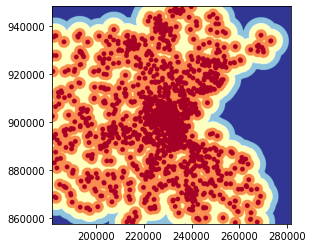

In [208]:
show(school_reclass, transform=transform, cmap='RdYlBu_r')
plt.show()

### 3.4 Euclidean Distance to Bus stops and Reclassify

In [209]:
Bus

OBJECTID  STOP_ID                     STOP_NAME     TOWN  TOWN_ID  \
0            1     3077  Gallivan Blvd @ opp Marsh St   BOSTON       35   
1            2      841       Lagrange St @ Virgil Rd   BOSTON       35   
2            3      446        Norfolk St @ Nelson St   BOSTON       35   
3            4      847     Lagrange St opp Virgil St   BOSTON       35   
4            5     3079           Adams St @ Minot St   BOSTON       35   
...        ...      ...                           ...      ...      ...   
7805      7806     9097         Grove St @ Lebanon St  MELROSE      178   
7806      7807     5911         Grove St @ Lebanon St  MELROSE      178   
7807      7808     5975  Wyoming Ave opp Cleveland St  MELROSE      178   
7808      7809    15976    Wyoming Ave @ Cleveland St  MELROSE      178   
7809      7810     5912           Grove St @ Faxon St  MELROSE      178   

                           geometry  
0     POINT (237120.669 892643.408)  
1     POINT (227915.195 892644.017)  
2     POINT (234385.661 892644.944)  
3     POINT (227912.601 892650.156)  
4     POINT (236644.812 892651.990)  
...                             ...  
7805  POINT (236229.381 911541.866)  
7806  POINT (236236.036 911542.538)  
7807  POINT (234977.387 911544.999)  
7808  POINT (234971.098 911547.184)  
7809  POINT (236456.969 911577.351)  

[7810 rows x 6 columns]

Text(0.5, 0.98, 'Bus stops in Boston Region')

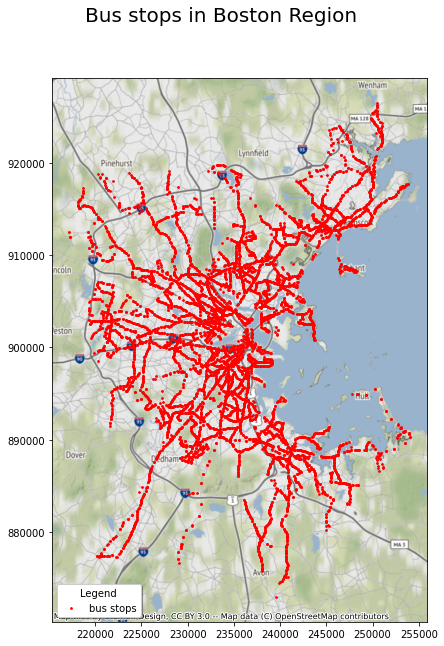

In [210]:
Busax = Bus.plot(figsize=(20, 10), legend=True, markersize=3, label='bus stops', color='red')
cx.add_basemap(Busax, crs=zctaBoston.crs.to_string());
Busax.legend(title="Legend", loc='lower left', ncol=5, shadow=True)
plt.suptitle('Bus stops in Boston Region', fontsize=20)

In [211]:
Bus.crs

<Projected CRS: EPSG:26986>
Name: NAD83 / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [212]:
Bus6491 = Bus.to_crs('epsg:6491')

In [213]:
Bus_raster = features.rasterize(Bus6491['geometry'], out_shape=shape, fill=1, transform=transform, default_value=0)

In [214]:
Bus_distance = ndimage.distance_transform_edt(Bus_raster) * res[0]

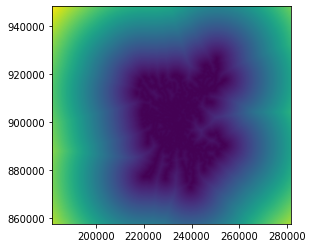

In [215]:
show(Bus_distance, transform=transform)
plt.show()

In [216]:
Bus_distance

array([[48237.79845723, 48214.89085335, 48191.99103586, ...,
        37842.17884848, 37866.63174881, 37891.09262083],
       [48218.43734507, 48195.52053874, 48172.61151318, ...,
        37824.80138745, 37849.26551467, 37873.73760272],
       [48199.08712828, 48176.1611173 , 48153.24288145, ...,
        37807.43974405, 37831.91509823, 37856.39840238],
       ...,
       [43122.60775974, 43095.91627985, 43069.22915493, ...,
        41986.76577209, 42008.33488726, 42029.91434681],
       [43136.3072133 , 43109.62421548, 43082.94558175, ...,
        42007.62787876, 42029.18628763, 42050.75504673],
       [43150.02317496, 43123.34866404, 43096.67852631, ...,
        42028.50104393, 42050.04875146, 42071.60681505]])

In [217]:
# Reclassify
Bus_reclass = np.full(shape, np.NaN)
Bus_reclass[Bus_distance <= 1000] = 5
Bus_reclass[(Bus_distance > 1000) & (Bus_distance <= 2000)] = 4
Bus_reclass[(Bus_distance > 2000) & (Bus_distance <= 3000)] = 3
Bus_reclass[(Bus_distance > 3000) & (Bus_distance <= 4000)] = 2
Bus_reclass[Bus_distance > 4000] = 1

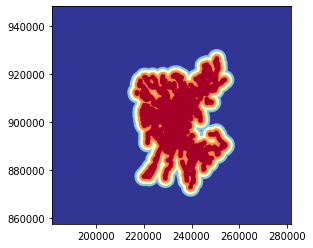

In [218]:
show(Bus_reclass, transform=transform, cmap='RdYlBu_r')
plt.show()

### 3.5 Land Cover Reclassify

In [219]:
crs

CRS.from_epsg(6491)

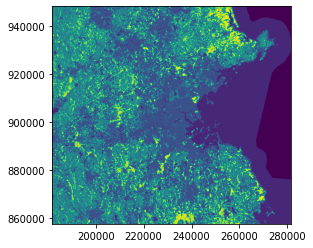

In [220]:
show(landcover, transform=transform)
plt.show()

In [221]:
landcover

array([[41, 41, 41, ...,  0,  0,  0],
       [41, 41, 41, ...,  0,  0,  0],
       [41, 41, 41, ...,  0,  0,  0],
       ...,
       [43, 43, 43, ..., 11, 11, 11],
       [43, 43, 43, ..., 11, 11, 11],
       [41, 43, 43, ..., 11, 11, 11]], dtype=uint8)

In [222]:
landcover_reclass = np.full(shape, np.NaN)

In [223]:
# Reclassify
landcover_reclass[(landcover > 20) & (landcover <= 24)] = 5
landcover_reclass[(landcover > 50) & (landcover <= 52)] = 4
landcover_reclass[(landcover > 40) & (landcover <= 43)] = 3
landcover_reclass[(landcover > 70) & (landcover <= 74)] = 3
landcover_reclass[(landcover > 80) & (landcover <= 82)] = 2

In [224]:
landcover_reclass[(landcover > 89) & (landcover < 91)] = 1
landcover_reclass[(landcover > 94) & (landcover < 96)] = 1
landcover_reclass[(landcover > 10) & (landcover < 13)] = 1
landcover_reclass[(landcover > 30) & (landcover < 32)] = 1

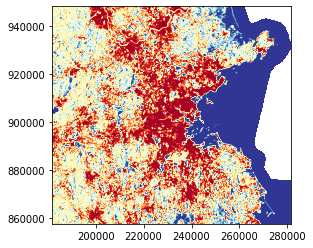

In [225]:
show(landcover_reclass, transform=transform, cmap='RdYlBu_r')
plt.show()

### 3.6 The Number of Library in each ZCTA (Attribute join)

In [226]:
library_group = library['WEBSITE'].groupby(library['ZIP']).agg(['count'])
library_group

count
ZIP         
01001      1
01002      4
01005      1
01007      1
01008      1
...      ...
02771      1
02777      1
02779      1
02780      1
02790      1

[417 rows x 1 columns]

In [227]:
# Attribute Join
library_merge=library_group.merge(zctaBoston,left_on='ZIP', right_on='ZCTA5CE10')
library_merge

count STATEFP10 ZCTA5CE10  GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10  \
0        1        25     01432  2501432        B5   G6350          S   
1        1        25     01450  2501450        B5   G6350          S   
2        1        25     01451  2501451        B5   G6350          S   
3        1        25     01460  2501460        B5   G6350          S   
4        1        25     01503  2501503        B5   G6350          S   
..     ...       ...       ...      ...       ...     ...        ...   
156      1        25     02481  2502481        B5   G6350          S   
157      2        25     02482  2502482        B5   G6350          S   
158      1        25     02493  2502493        B5   G6350          S   
159      1        25     02494  2502494        B5   G6350          S   
160      1        25     02762  2502762        B5   G6350          S   

      ALAND10  AWATER10   INTPTLAT10  ... OBJECTID            MPO  created_us  \
0    21888062   1219817  +42.5665731  ...       12  Boston Region        None   
1    84853731   2575943  +42.6117600  ...       12  Boston Region        None   
2    49550919   1682988  +42.5019084  ...       12  Boston Region        None   
3    42791669   2583059  +42.5359311  ...       12  Boston Region        None   
4    33598202    523984  +42.3849290  ...       12  Boston Region        None   
..        ...       ...          ...  ...      ...            ...         ...   
156  14612716    246885  +42.3119273  ...       12  Boston Region        None   
157  10898492   1043141  +42.2931365  ...       12  Boston Region        None   
158  43574801   1316917  +42.3605016  ...       12  Boston Region        None   
159   7166369    220234  +42.2994050  ...       12  Boston Region        None   
160  28482636   1350192  +42.0128003  ...       12  Boston Region        None   

     created_da last_edite  last_edi_1  \
0    1970-01-01   DINOCCOD  2018-04-18   
1    1970-01-01   DINOCCOD  2018-04-18   
2    1970-01-01   DINOCCOD  2018-04-18   
3    1970-01-01   DINOCCOD  2018-04-18   
4    1970-01-01   DINOCCOD  2018-04-18   
..          ...        ...         ...   
156  1970-01-01   DINOCCOD  2018-04-18   
157  1970-01-01   DINOCCOD  2018-04-18   
158  1970-01-01   DINOCCOD  2018-04-18   
159  1970-01-01   DINOCCOD  2018-04-18   
160  1970-01-01   DINOCCOD  2018-04-18   

                                   GlobalID    ShapeSTAre    ShapeSTLen  \
0    {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   
1    {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   
2    {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   
3    {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   
4    {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   
..                                      ...           ...           ...   
156  {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   
157  {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   
158  {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   
159  {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   
160  {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   

                                              geometry  
0    MULTIPOLYGON (((196989.369 922360.464, 196928....  
1    MULTIPOLYGON (((199473.636 924623.587, 199062....  
2    MULTIPOLYGON (((196167.819 911523.166, 196166....  
3    POLYGON ((200187.220 917547.104, 200086.541 91...  
4    MULTIPOLYGON (((190444.641 900460.257, 190380....  
..                                                 ...  
156  MULTIPOLYGON (((216227.448 893498.801, 216199....  
157  MULTIPOLYGON (((214323.693 894860.341, 214317....  
158  POLYGON ((219855.053 898442.328, 219856.802 89...  
159  POLYGON ((223666.678 895101.507, 223678.854 89...  
160  MULTIPOLYGON (((217517.748 863603.299, 217517....  

[161 rows x 22 columns]

In [228]:
gdf_merge=gpd.GeoDataFrame(library_merge)

Text(0.5, 0.98, 'Density of Library in ZCTAs of Boston Region')

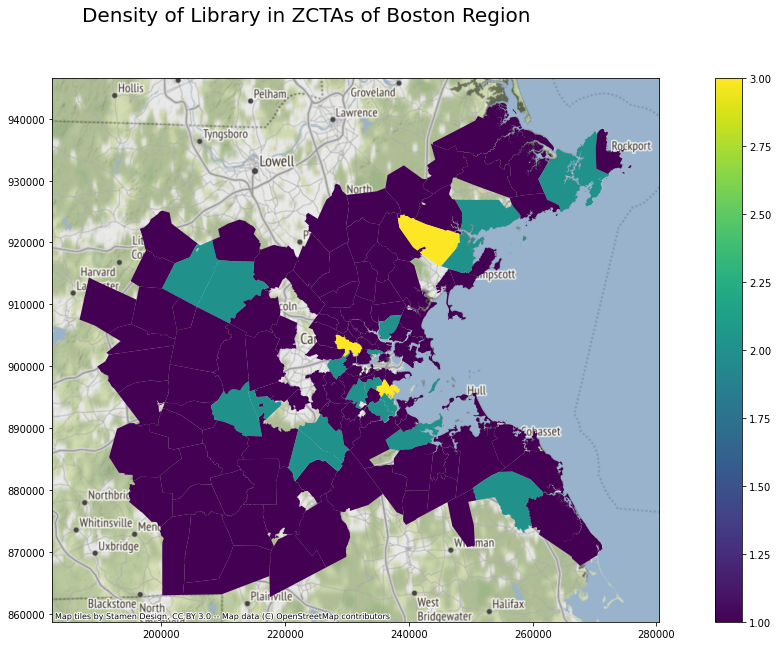

In [229]:
gdf_mergeax = gdf_merge.plot(figsize=(20, 10), column='count', legend=True)
cx.add_basemap(gdf_mergeax, crs=zctaBoston.crs.to_string());
plt.suptitle('Density of Library in ZCTAs of Boston Region', fontsize=20)

In [230]:
library_merge.sort_values('count',ascending=False)

count STATEFP10 ZCTA5CE10  GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10  \
111      3        25     02138  2502138        B5   G6350          S   
62       3        25     01960  2501960        B5   G6350          S   
100      3        25     02125  2502125        B5   G6350          S   
140      2        25     02351  2502351        B5   G6350          S   
71       2        25     02026  2502026        B5   G6350          S   
..     ...       ...       ...      ...       ...     ...        ...   
55       1        25     01929  2501929        B5   G6350          S   
57       1        25     01938  2501938        B5   G6350          S   
58       1        25     01940  2501940        B5   G6350          S   
59       1        25     01944  2501944        B5   G6350          S   
160      1        25     02762  2502762        B5   G6350          S   

      ALAND10  AWATER10   INTPTLAT10  ... OBJECTID            MPO  created_us  \
111   7097709    838564  +42.3796372  ...       12  Boston Region        None   
62   41432495   1461233  +42.5342016  ...       12  Boston Region        None   
100   5523791    799283  +42.3157481  ...       12  Boston Region        None   
140  25007126    617669  +42.1199641  ...       12  Boston Region        None   
71   26532271   1037912  +42.2468719  ...       12  Boston Region        None   
..        ...       ...          ...  ...      ...            ...         ...   
55   36187007   5125535  +42.6344210  ...       12  Boston Region        None   
57   78817223  13930917  +42.6838596  ...       12  Boston Region        None   
58   27320434   1710864  +42.5341175  ...       12  Boston Region        None   
59   23902799   3207908  +42.5766364  ...       12  Boston Region        None   
160  28482636   1350192  +42.0128003  ...       12  Boston Region        None   

     created_da last_edite  last_edi_1  \
111  1970-01-01   DINOCCOD  2018-04-18   
62   1970-01-01   DINOCCOD  2018-04-18   
100  1970-01-01   DINOCCOD  2018-04-18   
140  1970-01-01   DINOCCOD  2018-04-18   
71   1970-01-01   DINOCCOD  2018-04-18   
..          ...        ...         ...   
55   1970-01-01   DINOCCOD  2018-04-18   
57   1970-01-01   DINOCCOD  2018-04-18   
58   1970-01-01   DINOCCOD  2018-04-18   
59   1970-01-01   DINOCCOD  2018-04-18   
160  1970-01-01   DINOCCOD  2018-04-18   

                                   GlobalID    ShapeSTAre    ShapeSTLen  \
111  {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   
62   {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   
100  {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   
140  {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   
71   {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   
..                                      ...           ...           ...   
55   {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   
57   {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   
58   {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   
59   {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   
160  {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09  1.665026e+06   

                                              geometry  
111  POLYGON ((228178.405 903580.338, 228173.291 90...  
62   MULTIPOLYGON (((238286.607 923464.643, 238199....  
100  POLYGON ((235239.626 895597.505, 235250.427 89...  
140  MULTIPOLYGON (((248324.543 872352.955, 248317....  
71   POLYGON ((227939.083 889725.341, 227939.994 88...  
..                                                 ...  
55   MULTIPOLYGON (((262393.691 932771.243, 262363....  
57   MULTIPOLYGON (((262910.103 933890.845, 262920....  
58   POLYGON ((235677.234 919407.211, 235668.031 91...  
59   MULTIPOLYGON (((259015.480 922650.217, 259011....  
160  MULTIPOLYGON (((217517.748 863603.299, 217517....  

[161 rows x 22 columns]

## By calculation, there are currently three ZCTAs with the largest number of libraries (3). They are 02138,01960 and 02125

## 4. Calculate weighted Raster and Suitability Analysis

In [231]:
# Same weight for five factors
weighted = landcover_reclass * 0.2 + Bus_reclass * 0.2 + school_reclass * 0.2 + college_reclass * 0.2 + library_reclass * 0.2

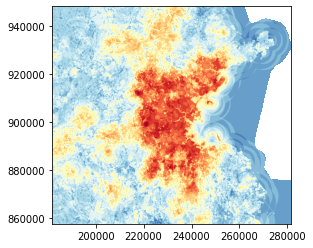

In [232]:
show(weighted, transform=transform, cmap='RdYlBu_r')
plt.show()

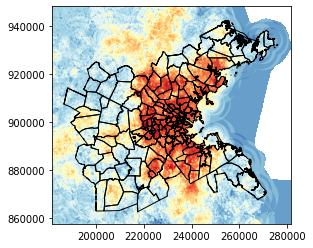

In [233]:
ax = zctaBoston.plot(facecolor='None', edgecolor='black')
show(weighted, cmap='RdYlBu_r', ax=ax, transform=transform)
plt.show()

In [234]:
zctaBoston_raster = features.rasterize(zctaBoston['geometry'], out_shape=shape, fill=1, transform=transform, default_value=0)

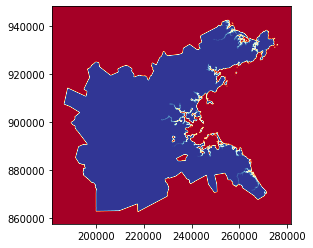

In [235]:
show(zctaBoston_raster, transform=transform, cmap='RdYlBu_r')
plt.show()

In [236]:
weighted[zctaBoston_raster == 1] = np.NaN

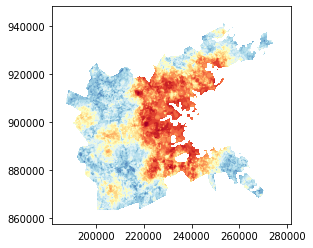

In [237]:
show(weighted, transform=transform, cmap='RdYlBu_r')
plt.show()

In [238]:
# Zonal Statistics
stats = pd.DataFrame(zonal_stats(zctaBoston, weighted, affine=transform, stats=['mean', 'count'], nodata = np.NaN))

In [239]:
stats

mean  count
0    3.875646  10914
1    3.831809  14455
2    2.358070  76790
3    3.628415  44280
4    2.329032     31
..        ...    ...
192  4.188955   3857
193  3.957710  14514
194  3.811197   6055
195  3.793368  18035
196  3.100000      6

[197 rows x 2 columns]

In [240]:
zone_join = zctaBoston.join(stats)

Text(0.5, 0.98, 'Suitable Areas of New Library in Boston Region ZCTAs')

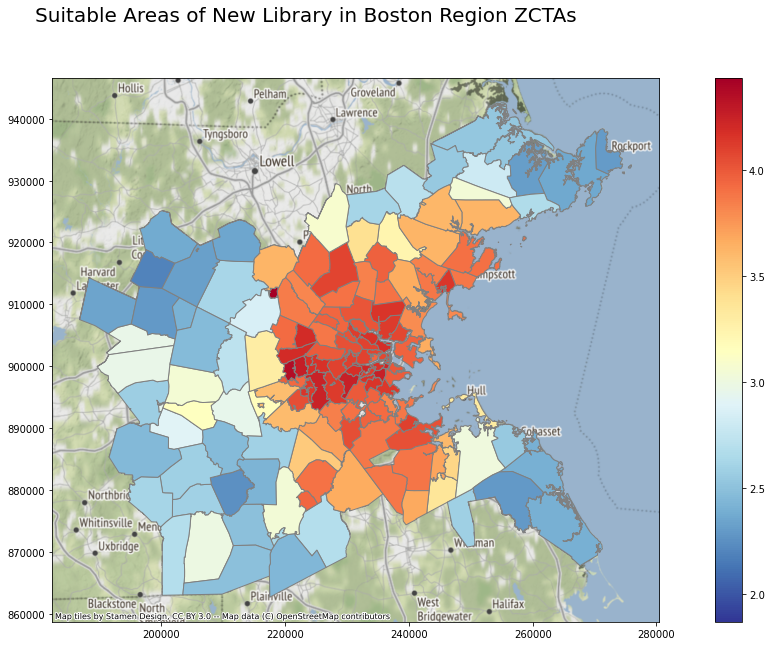

In [245]:
# Suitablity Analysis for new library
zone_joinax = zone_join.plot(figsize=(20, 10),column = 'mean', cmap='RdYlBu_r', legend=True, edgecolor='gray')
cx.add_basemap(zone_joinax, crs=zctaBoston.crs.to_string());
plt.suptitle('Suitable Areas of New Library in Boston Region ZCTAs', fontsize=20)

In [244]:
zone_join.sort_values('mean',ascending=False).head(1)

STATEFP10 ZCTA5CE10  GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10  ALAND10  \
79        25     01731  2501731        B5   G6350          S  2049705   

    AWATER10   INTPTLAT10    INTPTLON10  ... created_us  created_da  \
79         0  +42.4567483  -071.2794840  ...       None  1970-01-01   

   last_edite  last_edi_1                                GlobalID  \
79   DINOCCOD  2018-04-18  {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}   

      ShapeSTAre    ShapeSTLen  \
79  3.524379e+09  1.665026e+06   

                                             geometry      mean  count  
79  POLYGON ((218697.089 912144.975, 218701.865 91...  4.432702   2269  

[1 rows x 23 columns]

### Conclusion: The highest scored ZCTA is 01731, indicating that a new library is most appropriate in this area. And the number of existing libraries in this area is small, which meets our requirements for new libraries.